# Importing Required Libraries

In [1]:
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
from keras.datasets import cifar100
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras as ks
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import albumentations as albu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Mounted at /content/gdrive


# Model Constants

In [2]:
# parameters for data
height = 32
width = 32
channels = 3
input_shape = (height, width, channels)
n_classes = 100
# parameters for optimizers
lr = 0.001
# Parameters for training
epochs = 100
batch_size = 8
# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

# Loading Cifar100 data

In [4]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of y_train : ", y.shape)
print("The shape of X_test : ", X_test.shape)
print("The shape of y_test : ", y_test.shape)

# Cifar 100 labels
fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed',
                    'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 
                    'bridge', 'bus', 'butterfly','camel', 'can', 'castle',
                    'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatensorflowish',
                    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo',
                    'computer_keyboard','lamp', 'lawn_mower', 'leopard', 'lion',
                    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
                    'mountain', 'mouse', 'mushroom','oak_tree', 'orange', 
                    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
                    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                    'possum','rabbit', 'raccoon', 'ray', 'road', 'rocket',
                    'rose','sea', 'seal', 'shark', 'shrew', 'skunk', 
                    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
                    'streetcar', 'sunflower', 'sweet_pepper','table', 'tank',
                    'telephone', 'television', 'tiger', 'tractor', 'train',
                    'trout', 'tulip', 'turtle','wardrobe', 'whale', 
                    'willow_tree', 'wolf', 'woman', 'worm']   

The shape of X_train :  (50000, 32, 32, 3)
The shape of y_train :  (50000, 1)
The shape of X_test :  (10000, 32, 32, 3)
The shape of y_test :  (10000, 1)


# Preprocessing Data

In [35]:
def unison_shuffled_copies(a, b):
  randomize = np.arange(len(a))
  np.random.shuffle(randomize)
  x = a[randomize]
  y = b[randomize]
  return x, y

# Shuffling dataset
X, y = unison_shuffled_copies(X, y)
X_test, y_test = unison_shuffled_copies(X_test, y_test)

# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index],y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

The number of training data :  40000
The number of validation data :  10000


# Visualizing Some Samples

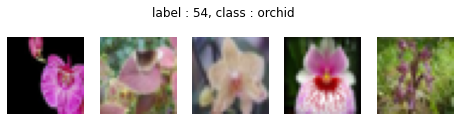

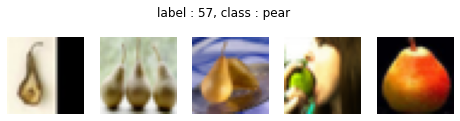

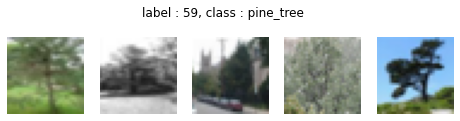

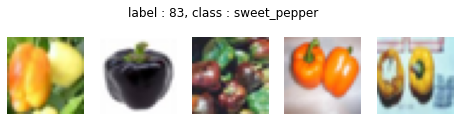

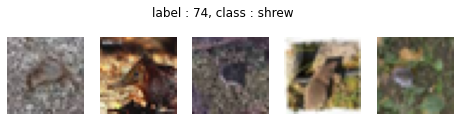

In [43]:
num_classes= 5 # Number of classes visualized
num_samples= 5 # Number of samples from each class
class_plotted = np.random.choice(range(n_classes),num_classes, replace = False)
for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:num_samples]
    fig, ax = plt.subplots(nrows = 1, ncols = num_samples, figsize=(8,2) )
    fig.suptitle("label : %d, class : %s" % (class_plotted[i],
                                             fine_label_list[class_plotted[i]]))
    for j in range(num_samples):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off') 

plt.show()

# Image Augmentation

In [9]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
          # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = img_batch[i]
            
        return img_batch

train_generator = DataGenerator(X_train, y_train, augment = False)
valid_generator = DataGenerator(X_val, y_val, augment = False)

# Building and Compiling Network

In [10]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(BatchNormalization())

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
optimizer_1 = Adam(learning_rate= lr)
model.compile(loss="categorical_crossentropy", 
              optimizer= optimizer_1, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                        

# Training Model

In [ ]:
data_dir1 = '/content/gdrive/My Drive/Vision_Project/CNN/CNN_checkpoint.hdf5'
mc = ModelCheckpoint(filepath=data_dir1, monitor='loss' , verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, factor = decay_rate, min_lr = 1e-6, verbose = 1)

modelhistory = model.fit(train_generator,validation_data = valid_generator, epochs = epochs, verbose = 1, callbacks = [es, rlrop, mc])

model.save_weights("/content/gdrive/My Drive/Vision_Project/CNN/CNN_weights.hdf5")
model.save("/content/gdrive/My Drive/Vision_Project/CNN/CNN_model.hdf5")

Epoch 1/100
4999/5000 [============================>.] - ETA: 0s - loss: 4.0809 - accuracy: 0.0866
Epoch 00001: loss improved from inf to 4.08082, saving model to /content/gdrive/My Drive/Vision_Project/CNN/CNN_checkpoint.hdf5
5000/5000 [==============================] - 212s 42ms/step - loss: 4.0808 - accuracy: 0.0866 - val_loss: 3.6286 - val_accuracy: 0.1501 - lr: 0.0010
Epoch 2/100
4999/5000 [============================>.] - ETA: 0s - loss: 3.5763 - accuracy: 0.1527
Epoch 00002: loss improved from 4.08082 to 3.57631, saving model to /content/gdrive/My Drive/Vision_Project/CNN/CNN_checkpoint.hdf5
5000/5000 [==============================] - 206s 41ms/step - loss: 3.5763 - accuracy: 0.1527 - val_loss: 3.4074 - val_accuracy: 0.1962 - lr: 0.0010
Epoch 3/100
5000/5000 [==============================] - ETA: 0s - loss: 3.3172 - accuracy: 0.1943
Epoch 00003: loss improved from 3.57631 to 3.31718, saving model to /content/gdrive/My Drive/Vision_Project/CNN/CNN_checkpoint.hdf5
5000/5000 [==

# Resume Training

In [11]:
data_dir1 = '/content/gdrive/My Drive/Vision_Project/CNN/CNN_checkpoint.hdf5'
model.load_weights(data_dir1)
mc = ModelCheckpoint(filepath=data_dir1, monitor='loss' , verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, factor = decay_rate, min_lr = 1e-6, verbose = 1)

modelhistory = model.fit(train_generator,validation_data = valid_generator, epochs = 1, verbose = 1, callbacks = [es, rlrop, mc])

model.save_weights("/content/gdrive/My Drive/Vision_Project/CNN/CNN_weights.hdf5")
model.save("/content/gdrive/My Drive/Vision_Project/CNN/CNN_model.hdf5")

4996/5000 [============================>.] - ETA: 0s - loss: 2.2615 - accuracy: 0.4064
Epoch 00001: loss improved from inf to 2.26174, saving model to /content/gdrive/My Drive/Vision_Project/CNN/CNN_checkpoint.hdf5
5000/5000 [==============================] - 67s 11ms/step - loss: 2.2617 - accuracy: 0.4063 - val_loss: 1.8750 - val_accuracy: 0.4928 - lr: 0.0010


# Testing Model

In [14]:
test_generator = DataGenerator(X_test, y_test, augment = False)
test_loss, test_accuracy = model.evaluate(test_generator)
y_pred = model.predict(X_test)

y_pred2=[]
for i in range(len(y_pred)):
  y_pred2.append( np.argmax(y_pred[i]) )
  
test_accuracy *=  100
print(classification_report(y_test, y_pred2))
print("Accuracy: "+str(test_accuracy)+ " %")
print('\n')

1250/1250 [==============================] - 7s 6ms/step - loss: 2.3179 - accuracy: 0.4030
              precision    recall  f1-score   support

           0       0.36      0.04      0.07       100
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.00      0.00      0.00       100
           8       0.00      0.00      0.00       100
           9       0.13      0.08      0.10       100
          10       0.00      0.00      0.00       100
          11       0.00      0.00      0.00       100
          12       0.00      0.00      0.00       100
          13       0.20      0.01      0.02       100
          14       0.25      0.01      0.02       100
          15       0.00      0.00      0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test Metrics

In [16]:
conf_matrix = confusion_matrix(y_true= y_test, y_pred= y_pred2)
                               
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

ids = ['TP rate', 'TN rate',  'Precision',  'N prediction value', 
       'FP rate', 'FN rate' ,'FD rate', 'Acc']


df = pd.DataFrame( { 'TP': TP.round(3)
                   , 'TN': TN.round(3)
                   , 'FN': FN.round(3)
                   , 'FP': FP.round(3)
                   , ids[7]: ACC.round(3) 
                   , ids[0]: TPR.round(3)
                   , ids[1]: TNR.round(3)
                   , ids[2]: PPV.round(3)
                   , ids[4]: FDR.round(3)
                   , ids[5]: FNR.round(3)
                   , ids[6]: FDR.round(3)
                   , ids[3]: NPV.round(3)  }
                  , index = fine_label_list  
                  )
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


,TP,TN,FN,FP,Acc,TP rate,TN rate,Precision,FP rate,FN rate,FD rate,N prediction value
apple,4,9893,96,7,0.990,0.04,0.999,0.364,0.636,0.96,0.636,0.990
aquarium_fish,0,9899,100,1,0.990,0.00,1.000,0.000,1.000,1.00,1.000,0.990
baby,0,9900,100,0,0.990,0.00,1.000,NaN,NaN,1.00,NaN,0.990
bear,0,9900,100,0,0.990,0.00,1.000,NaN,NaN,1.00,NaN,0.990
beaver,0,9900,100,0,0.990,0.00,1.000,NaN,NaN,1.00,NaN,0.990
...,...,...,...,...,...,...,...,...,...,...,...,...
whale,69,8473,31,1427,0.854,0.69,0.856,0.046,0.954,0.31,0.954,0.996
willow_tree,0,9900,100,0,0.990,0.00,1.000,NaN,NaN,1.00,NaN,0.990
wolf,0,9900,100,0,0.990,0.00,1.000,NaN,NaN,1.00,NaN,0.990
woman,0,9900,100,0,0.990,0.00,1.000,NaN,NaN,1.00,NaN,0.990


# Visualizing Performance

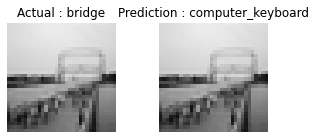

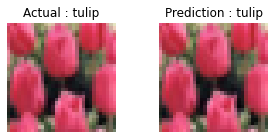

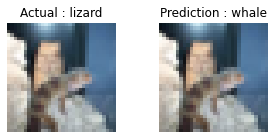

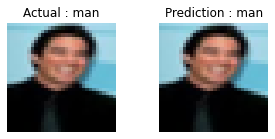

In [33]:
n_tests = 4
start = 32
image = X_test[start: start + n_tests]
labels = y_test[start: start + n_tests]
pred = y_pred2[start: start + n_tests]

for i in range(len(labels)):
  fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(5, 2))

  ax1.axis('off')
  ax1.imshow(image[i] , cmap=plt.cm.gray)
  ax1.set_title("Actual : " + str(fine_label_list[int(labels[i]) ]) )
  ax2.axis('off')
  ax2.imshow(image[i], cmap=plt.cm.gray)
  ax2.set_title('Prediction : '+ str( fine_label_list[int(pred[i] )] ))

plt.show()

# Graphing Test Accuracy

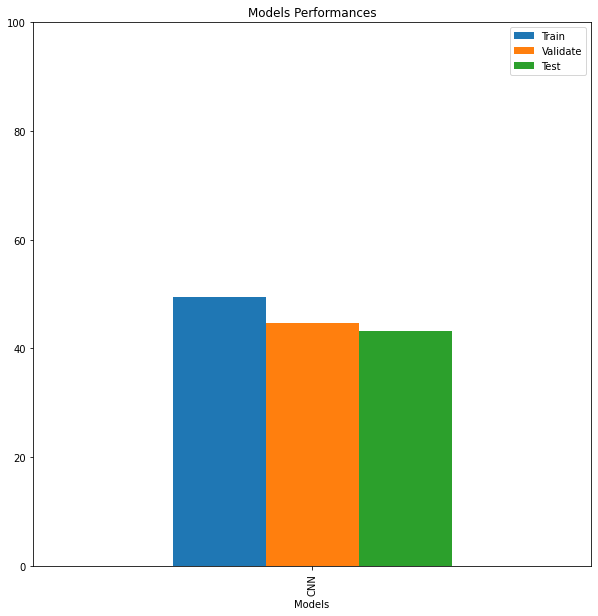

In [ ]:
df = pd.DataFrame([['CNN',
                    modelhistory.history["accuracy"][-1]*100 ,
                    modelhistory.history["val_accuracy"][-1]*100, test_accuracy]],
                  columns=['Models', 'Train', 'Validate', 'Test'])
df.plot(x='Models',
        kind='bar',
        stacked=False,
        figsize=(10,10),
        ylim=(0,100),
        title='Models Performances')